In [1]:
import pandas as pd
import os
import plotly
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import datetime

nhs_colours = ['#00A499', '#FFB81C', '#7C2855']

# Appointments Analysis

### What type of appointment did you get?

In [2]:
# import csv file
appointment_types = pd.read_csv('data/Appoinment_types.csv', sep=',', header=0)
# rename blank first col
appointment_types.rename({' ':'Appointemnt Types'}, axis=1, inplace=True)
appointment_types

,Appointemnt Types,2018,2019,2020,2021
0,To speak to someone on the phone,58654,60756,59375,309311
1,To speak to someone online (for example on a v...,393,596,970,17047
2,To see someone at another general practice loc...,20082,24930,26545,16622
3,To see someone at my GP practice,548877,549943,514151,313459
4,For a home visit,5351,4944,4451,3228


In [3]:
# create a dict of appointments and there coresponding type
grouptype = {
    'To speak to someone on the phone': 'Remote',
    'To speak to someone online (for example on a video call)': 'Remote',
    'To see someone at another general practice location': 'In person',
    'To see someone at my GP practice': 'In person',
    'For a home visit': 'In person'
    }
# make a new col that maps the groups to the appointments
appointment_types['Group Type'] = appointment_types['Appointemnt Types'].map(grouptype)
appointment_types

,Appointemnt Types,2018,2019,2020,2021,Group Type
0,To speak to someone on the phone,58654,60756,59375,309311,Remote
1,To speak to someone online (for example on a v...,393,596,970,17047,Remote
2,To see someone at another general practice loc...,20082,24930,26545,16622,In person
3,To see someone at my GP practice,548877,549943,514151,313459,In person
4,For a home visit,5351,4944,4451,3228,In person


In [4]:
# now we can groupby type and sum the yearly counts
appointment_types_group = appointment_types.groupby('Group Type').sum().reset_index()
# melt is like an inverse pivot, changing the data to 'long' format (one observeation per row)
appointment_types_group = pd.melt(appointment_types_group, id_vars='Group Type', value_vars=['2018', '2019', '2020', '2021'])
appointment_types_group.columns = ["Appointment Type", "Year", "Count"]
appointment_types_group

,Appointment Type,Year,Count
0,In person,2018,574310
1,Remote,2018,59047
2,In person,2019,579817
3,Remote,2019,61352
4,In person,2020,545147
5,Remote,2020,60345
6,In person,2021,333309
7,Remote,2021,326358


In [5]:
# use groupby on years to get the total counts
appointment_year_total = appointment_types_group.groupby('Year').sum().reset_index()
appointment_year_total.rename(columns={'Count': 'Total'}, inplace=True)
appointment_year_total 

,Year,Total
0,2018,633357
1,2019,641169
2,2020,605492
3,2021,659667


In [6]:
# merge the totals back to the df
appointment_types_group = pd.merge(appointment_types_group, appointment_year_total, on='Year', how='left')
# calculate percentages
appointment_types_group['Percent'] = appointment_types_group['Count']/appointment_types_group['Total']
appointment_types_group

,Appointment Type,Year,Count,Total,Percent
0,In person,2018,574310,633357,0.906771
1,Remote,2018,59047,633357,0.093229
2,In person,2019,579817,641169,0.904312
3,Remote,2019,61352,641169,0.095688
4,In person,2020,545147,605492,0.900337
5,Remote,2020,60345,605492,0.099663
6,In person,2021,333309,659667,0.505269
7,Remote,2021,326358,659667,0.494731


### Appointments: data visualisation

In [7]:
# plot the long (tidy) dataframe
fig = px.bar(
    appointment_types_group,
    x="Year",
    y="Percent",
    color="Appointment Type",
    color_discrete_sequence=nhs_colours,
    # I would use the website to write chart titles in the correct font/foramt/spacing
    #title="Remote appointments are now as common as in person appointments",
    barmode="stack",
    text="Percent",
)

# Asthetics of the plot
fig.update_layout(
    # change background colour 
    {"plot_bgcolor": "rgba(0, 0, 0, 0)", "paper_bgcolor": "rgba(0, 0, 0, 0)"},
    yaxis_title='Of all appointments (%)',
    yaxis=dict(tickformat = "%"),
    xaxis_title='Year',
    # change fonts
    font=dict(family="Arial", size=16),
    # autosize makes the chart 'responsive' (https://en.wikipedia.org/wiki/Responsive_web_design)
    autosize=True,
    margin=dict(
        l=50,
        r=50,
        b=50,
        t=50,
        pad=4,
        autoexpand=True
        ),
    ## options for the hover-over text
    # changes how the hover-over box is displayed
    hovermode="x unified",
    # hoverlabel_align = 'right',
    # changes the hover-over box formatting
    hoverlabel=dict(
        bgcolor="white",
        font_size=16,
        font_family="Arial"
    )
)

# options to change how the bars look
fig.update_traces(
    # this also changes the hover-over box formatting
    hovertemplate='<b>%{fullData.name}</b>: %{text:.1%}<extra></extra>',
    # outline of bars
    marker_line_color = 'rgb(8,48,107)',
    marker_line_width=1.5,
    opacity=1,
    # options for text inside bars
    texttemplate='%{text:.1%}',
    textposition='inside'
)
fig.update_xaxes(type='category')
fig.show()

In [8]:
# Write chart to file (.html)
config = {"displayModeBar": False, "displaylogo": False}
plotly_obj = plotly.offline.plot(
    fig, include_plotlyjs=False, output_type="div", config=config
)
with open("_includes/remote_appts.html", "w") as file:
    file.write(plotly_obj)

In [9]:
## how did you try to book an appointment?
how_try_book_appointment = pd.read_csv(r'data/how_book_appointment.csv', sep=',', header=0)
how_try_book_appointment = how_try_book_appointment.rename(columns={
    "type": "Booking Type",
    'National_N': "Count"})

# create a dict of appointments and there coresponding type
grouptype = {
    'In person': 'In person',
    'By phone, through my practice': 'Telephone',
    'By automated telephone booking': 'Telephone',
    'Online, including on a website or through an app': 'Online'
    }
# make a new col that maps the groups to the appointments
how_try_book_appointment['Group Type'] = how_try_book_appointment['Booking Type'].map(grouptype)

# now we can groupby type and sum the yearly counts
how_try_book_appointment_group = how_try_book_appointment.groupby('Group Type').sum().reset_index()

# sum series to get total count
how_try_book_appointmen_total = how_try_book_appointment_group.sum(axis=0).values[1]

# calculate percentages
how_try_book_appointment_group['Percent'] = how_try_book_appointment_group['Count']/how_try_book_appointmen_total
how_try_book_appointment_group


,Group Type,Count,Percent
0,In person,65700,0.076663
1,Online,105510,0.123116
2,Telephone,685789,0.800221


In [21]:
fig = px.pie(how_try_book_appointment_group, color_discrete_sequence=nhs_colours, values='Percent', names='Group Type')

# Asthetics of the plot
fig.update_layout(
    # change background colour 
    {"plot_bgcolor": "rgba(0, 0, 0, 0)", "paper_bgcolor": "rgba(0, 0, 0, 0)"},
    # change fonts
    font=dict(family="Arial", size=16),
    # autosize makes the chart 'responsive' (https://en.wikipedia.org/wiki/Responsive_web_design)
    autosize=True,
    margin=dict(
        l=50,
        r=50,
        b=50,
        t=50,
        pad=4,
        autoexpand=True
        ),
    ## options for the hover-over text
    # changes how the hover-over box is displayed
    # hoverlabel_align = 'right',
    # changes the hover-over box formatting
    hoverlabel=dict(
        bgcolor="white",
        font_size=16,
        font_family="Arial"
    )
)
# options to change how the bars look
fig.update_traces(
    # this also changes the hover-over box formatting
    hovertemplate='<b>%{label}</b>: %{value:.1%}',
    # outline of bars
    marker_line_color = 'rgb(8,48,107)',
    marker_line_width=1.5,
    opacity=1,
    # options for text inside bars
    textposition='inside'
)


fig.show()

In [18]:
# Write chart to file (.html)
config = {"displayModeBar": False, "displaylogo": False}
plotly_obj = plotly.offline.plot(
    fig, include_plotlyjs=False, output_type="div", config=config
)
with open("_includes/booking_type.html", "w") as file:
    file.write(plotly_obj)

# GP online services

### Which of the following general practice online services have you used in the past 12 months?

In [11]:
# Could you change the file to data/Online_gp_services.csv
online_gp_services = pd.read_csv (r'data/Online_gp_services.csv', sep=',', header=0).dropna(axis='columns')
# remove those respondents that did not use any online service
online_gp_services = online_gp_services[~online_gp_services['Activity'].str.contains("None of these")]
online_gp_services = online_gp_services.rename(columns={
    "75_Over_N": "Aged 75+",
    '16_24_N': "Aged 16-25",
    'National_N': "All ages"})
online_gp_services = pd.melt(
    online_gp_services,
    id_vars=['Activity', 'Lable'],
    value_vars=[
        "Aged 75+",
        "Aged 16-25",
        "All ages"])
online_gp_services.columns = ["Online Activity", "Lable", "Age Group", "Count of Respondents"]

# use groupby on age to get the total counts
online_gp_services_total = online_gp_services.groupby('Age Group').sum().reset_index()
online_gp_services_total.rename(columns={'Count of Respondents': 'Total Respondents'}, inplace=True)

# merge the totals back to the df
online_gp_services = pd.merge(online_gp_services, online_gp_services_total, on='Age Group', how='left')
# calculate percentages
online_gp_services['Percent'] = online_gp_services['Count of Respondents']/online_gp_services['Total Respondents']
online_gp_services = online_gp_services.sort_values(['Percent', 'Age Group'])
online_gp_services

,Online Activity,Lable,Age Group,Count of Respondents,Total Respondents,Percent
2,Accessing my medical records online,Accessing my medical<br>records online,Aged 75+,2653,40601,0.065343
10,Accessing my medical records online,Accessing my medical<br>records online,All ages,58910,580894,0.101413
6,Accessing my medical records online,Accessing my medical<br>records online,Aged 16-25,6166,53718,0.114785
0,Booking appointments online,Booking appointments<br>online,Aged 75+,8710,40601,0.214527
3,Had an online consultation or appointment,Had an online<br>consultation or<br>appointment,Aged 75+,9408,40601,0.231718
11,Had an online consultation or appointment,Had an online<br>consultation or<br>appointment,All ages,148409,580894,0.255484
8,Booking appointments online,Booking appointments<br>online,All ages,155845,580894,0.268285
5,Ordering repeat prescriptions online,Ordering repeat<br>prescriptions online,Aged 16-25,14599,53718,0.271771
4,Booking appointments online,Booking appointments<br>online,Aged 16-25,16363,53718,0.304609
7,Had an online consultation or appointment,Had an online<br>consultation or<br>appointment,Aged 16-25,16590,53718,0.308835


In [20]:
# plot the long (tidy) dataframe
fig = px.bar(
    online_gp_services,
    x="Online Activity",
    y="Percent",
    color="Age Group",
    color_discrete_sequence=nhs_colours,
    barmode="group",
    text="Percent",
)

# Asthetics of the plot
fig.update_layout(
    # change background colour 
    {"plot_bgcolor": "rgba(0, 0, 0, 0)", "paper_bgcolor": "rgba(0, 0, 0, 0)"},
    yaxis_title='Of Respondents (%)',
    yaxis=dict(tickformat = "%"),
    xaxis=dict(
        tickmode = 'array',
        tickvals = online_gp_services['Online Activity'].tolist(),
        ticktext = online_gp_services['Lable'].tolist(),
        tickangle = 0
    ),
    # change fonts
    font=dict(family="Arial", size=16),
    # autosize makes the chart 'responsive' (https://en.wikipedia.org/wiki/Responsive_web_design)
    autosize=True,
    margin=dict(
        l=50,
        r=50,
        b=50,
        t=50,
        pad=4,
        autoexpand=True
        ),
    ## options for the hover-over text
    # changes how the hover-over box is displayed
    hovermode="x unified",
    # hoverlabel_align = 'right',
    # changes the hover-over box formatting
    hoverlabel=dict(
        bgcolor="white",
        font_size=16,
        font_family="Arial"
    )
)
# options to change how the bars look
fig.update_traces(
    # this also changes the hover-over box formatting
    hovertemplate='<b>%{fullData.name}</b>: %{text:.1%}<extra></extra>',
    # outline of bars
    marker_line_color = 'rgb(8,48,107)',
    marker_line_width=1.5,
    opacity=1,
    # options for text inside bars
    texttemplate='%{text:.1%}',
    textposition='inside',
    textangle = 90
    )
fig.update_xaxes(type='category')
fig.show()

In [13]:
# Write chart to file (.html)
config = {"displayModeBar": False, "displaylogo": False}
plotly_obj = plotly.offline.plot(
    fig, include_plotlyjs=False, output_type="div", config=config
)
with open("_includes/online_activities.html", "w") as file:
    file.write(plotly_obj)

## Trends - Using GP Websites

## How easy is it to use your GP practice’s website to look for information or access services?

In [93]:
# Over 75s (2018 - 2021)
ease_use_75_and_over = pd.read_csv (r'data/Ease_of_use_over_time_75+.csv', header = 0)
ease_use_75_and_over.columns = ["Year", "Age 75+"]

# 16-24s (2018 - 2021)
ease_16_24 = pd.read_csv (r'data/use_16_24.csv', header = 0)                                                                                                                                                 
ease_16_24.columns = ["Year", "Age 16-24"]

# Long term health conditions (2018 - 2021)
trend_ease_use_LTC = pd.read_csv (r'data/trend_ease_use_2021_time_long_term_condition.csv')
trend_ease_use_LTC = trend_ease_use_LTC.dropna(axis='rows')
trend_ease_use_LTC.columns = ["Year", "Long-term Cond."]

# merge
ease_of_use = ease_16_24.merge(ease_use_75_and_over,on='Year').merge(trend_ease_use_LTC,on='Year')
ease_of_use = pd.melt(
    ease_of_use,
    id_vars=['Year'],
    value_vars=[
        "Age 16-24",
        "Age 75+",
        "Long-term Cond."])
ease_of_use.columns = ["Year", "Group", "Percent"]
ease_of_use

,Year,Group,Percent
0,2018,Age 16-24,0.74
1,2019,Age 16-24,0.73
2,2020,Age 16-24,0.73
3,2021,Age 16-24,0.75
4,2018,Age 75+,0.84
5,2019,Age 75+,0.81
6,2020,Age 75+,0.80
7,2021,Age 75+,0.75
8,2018,Long-term Cond.,0.79
9,2019,Long-term Cond.,0.77


In [94]:
# plot the long (tidy) dataframe
fig = px.bar(
    ease_of_use,
    x="Year",
    y="Percent",
    color="Group",
    color_discrete_sequence=nhs_colours,
    barmode="group",
    text="Percent"
)

# Asthetics of the plot
fig.update_layout(
    # change background colour 
    {"plot_bgcolor": "rgba(0, 0, 0, 0)", "paper_bgcolor": "rgba(0, 0, 0, 0)"},
    yaxis_title='Of Respondents (%)',
    yaxis=dict(tickformat = "%"),
    # change fonts
    font=dict(family="Arial", size=16),
    # autosize makes the chart 'responsive' (https://en.wikipedia.org/wiki/Responsive_web_design)
    autosize=True,
    margin=dict(
        l=50,
        r=50,
        b=50,
        t=50,
        pad=4,
        autoexpand=True
        ),
    ## options for the hover-over text
    # changes how the hover-over box is displayed
    hovermode="x unified",
    # hoverlabel_align = 'right',
    # changes the hover-over box formatting
    hoverlabel=dict(
        bgcolor="white",
        font_size=16,
        font_family="Arial"
    )
)
# options to change how the bars look
fig.update_traces(
    # this also changes the hover-over box formatting
    hovertemplate='<b>%{fullData.name}</b>: %{text:.0%}<extra></extra>',
    # outline of bars
    marker_line_color = 'rgb(8,48,107)',
    marker_line_width=1.5,
    opacity=1,
    # options for text inside bars
    texttemplate='%{text:.0%}',
    textposition='inside',
    textangle = 90
    )
fig.update_xaxes(type='category')
fig.show()

In [16]:
# Write chart to file (.html)
config = {"displayModeBar": False, "displaylogo": False}
plotly_obj = plotly.offline.plot(
    fig, include_plotlyjs=False, output_type="div", config=config
)
with open("_includes/ease_of_use.html", "w") as file:
    file.write(plotly_obj)

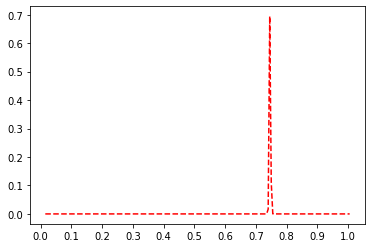

In [85]:
# stats
from statsmodels.stats.proportion import proportions_ztest
count = 22643
nObs = 30558
value = 0.01
values = []
pvals = []
iter = range(1,200)
for i in iter:
    stat, pval = proportions_ztest(count, nObs, value)
    value = value + 0.005
    pvals.append(pval)
    values.append(value)

import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
fig, ax = plt.subplots()
ax.plot(values, pvals, 'r--')
loc = plticker.MultipleLocator(base=0.1) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
plt.show()

## Hold for Ofcom digital exclusion data 

In [17]:
## What would promt you to go online chart